In [3]:
from params import LocationConfig, TrainingConfig, CreateDataConfig, NetworkConfig
from datamodule import Datamodule
from models.cnn7 import CNN7

from pathlib import Path
from tqdm import tqdm
from glob import glob
import numpy as np
import cv2

import torchvision.transforms as transforms
from torch.nn import functional as F
from torchsummary import summary
import torch

In [4]:
cnn7 = CNN7(
        lr=NetworkConfig.lr,
        batch_norm=NetworkConfig.batch_norm,
        negative_slope=NetworkConfig.negative_slope,
        dropout = NetworkConfig.dropout
        )
summary(cnn7.cuda(), (311, 243, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 311, 243]             448
              ReLU-2         [-1, 16, 311, 243]               0
           Dropout-3         [-1, 16, 311, 243]               0
         MaxPool2d-4         [-1, 16, 155, 121]               0
            Conv2d-5         [-1, 32, 155, 121]           4,640
         MaxPool2d-6           [-1, 32, 77, 60]               0
            Conv2d-7           [-1, 64, 77, 60]          18,496
         MaxPool2d-8           [-1, 64, 38, 30]               0
            Conv2d-9          [-1, 128, 38, 30]          73,856
        MaxPool2d-10          [-1, 128, 19, 15]               0
           Conv2d-11          [-1, 256, 19, 15]         295,168
        MaxPool2d-12            [-1, 256, 9, 7]               0
           Conv2d-13            [-1, 512, 9, 7]       1,180,160
        MaxPool2d-14            [-1, 51

In [4]:
checkpoints_dir = Path(LocationConfig.checkpoints_dir)
list_of_checkpoints = list(checkpoints_dir.glob("*.ckpt"))
latest_checkpoint_path = max(list_of_checkpoints, key=lambda p: p.stat().st_ctime)

cnn4 = CNN4(lr=0.0001, batch_norm=False, dropout=0.2, batch_size=2, negative_slope=0.0)\
    .load_from_checkpoint(checkpoint_path=latest_checkpoint_path)
cnn4.eval();
cnn4.state_dict()['conv.conv_0.weight'][0]

tensor([[[ 0.2577,  0.2794, -0.0790],
         [ 0.3109, -0.0686,  0.0687],
         [-0.1655,  0.1929,  0.2899]]])

In [5]:
train_data_path = Path(LocationConfig.data + 'train')
test_data_path = Path(LocationConfig.data + 'test')
dm = Datamodule(
        batch_size=TrainingConfig.batch_size,
        train_dir=train_data_path,
        val_dir=test_data_path,
        )
# dm.setup(val_only=True)
dm.setup()

file: data/BFD/train/train.pickle
file: data/BFD/test/test.pickle


In [36]:
image.permute(2,0,1).shape

torch.Size([3, 311, 243])

 33%|███▎      | 1/3 [00:00<00:01,  1.55it/s]


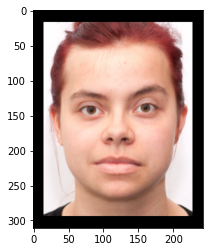

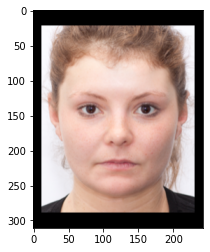

In [42]:
from matplotlib import pyplot as plt
i=0
for batch in tqdm(dm.val_dataloader()):
    image = batch['normalized'][0,:,:]
    plt.figure()
    plt.imshow(cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB))
    if i == 1:
        break
    i+=1

In [18]:
acc_class_global_1 = np.zeros(5)
acc_class_global_12 = np.zeros(5)
i=0
for batch in tqdm(dm.val_dataloader()):
    X, Y = batch['original'], batch['label']
    Y_pred = cnn4.predict_step(X, None)
    Y_pred_12 = np.where(Y_pred > 1/2, 1, 0)
    Y_pred_1 = np.ones_like(Y)
    acc_class_12 = np.sum(Y_pred_12 == np.array(Y), axis=0) / len(Y)
    acc_class_1 = np.sum(Y_pred_1 == np.array(Y), axis=0) / len(Y)
    acc_class_global_12 += acc_class_12
    acc_class_global_1 += acc_class_1
    i+=1
acc_class_global_12 /= i
print('1/2')
print(acc_class_global_12)
print(acc_class_global_12.mean())

acc_class_global_1 /= i
print('1')
print(acc_class_global_1)
print(acc_class_global_1.mean())

  0%|          | 0/3 [00:00<?, ?it/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor